# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import patsy
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold

%matplotlib inline

## Load the data into a DataFrame
df = pd.read_csv('starter-code/Iowa_Liquor_sales_sample_10pct.csv')

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)

## Rename some columns for ease of future operations
df = df.rename(columns={'Date':'date', 'Store Number': 'storenumber', 'Zip Code': 'zipcode', 
                        'City':'city', 'Vendor Number': 'vendornumber', 'County Number': 'countynumber', 
                        'County':'county','Bottle Volume (ml)':'bv_ml', 'State Bottle Cost':'sbc', 
                        'Category':'category','State Bottle Retail': 'sbr', 'Bottles Sold':'bottles_sold', 
                        'Category Name':'categoryname','Sale (Dollars)': 'sale_in_dollars', 
                        'Volume Sold (Liters)':'vs_lit', 'Volume Sold (Gallons)':'vs_gal', 
                        'Item Number':'itemnumber', 'Item Description':'itemdesc'})

## Strip '$' from columns containing dollar amounts to aid pandas operations on respective columns

df['sale_in_dollars'] = df['sale_in_dollars'].apply(lambda x: float(x[1:]))
df['sbc'] = df['sbc'].apply(lambda x: float(x[1:]))
df['sbr'] = df['sbr'].apply(lambda x: float(x[1:]))

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [3]:
df.head(3)

,date,storenumber,city,zipcode,countynumber,county,category,categoryname,vendornumber,itemnumber,itemdesc,bv_ml,sbc,sbr,bottles_sold,sale_in_dollars,vs_lit,vs_gal
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34


In [4]:
# For columns expected to contain only values of types int and float,
# one easy test for invalid values (anything non-numeric besides NaN)
# would be to try to temporarily cast the entire column as type int64
# or float64. Should there be presence of invalid values, we can then
# investigate the column further. 

# This test does not consider 

numint_columns = ['storenumber','zipcode','vendornumber','itemnumber','bv_ml']
numflt_columns = ['countynumber','category','sbc','sbr','sale_in_dollars','vs_lit','vs_gal']

for ncol in numint_columns:
    try:
        df[ncol].astype('int64')
    except:
        print "Problem casting type for column %s"%ncol

for ncol in numflt_columns:
    try:
        df[ncol].astype('float64')
    except:
        print "Problem casting type for column %s"%ncol


Problem casting type for column zipcode


In [5]:
# Issues found with the column 'zipcode'
# As the expected format of this column is a 5-digit integer, match values
# against the appropriate regular expression and return all rows failing
# the comparison. 

import re
from collections import Counter

indices = [i for i, x in enumerate(df['zipcode']) if not re.search(r'^\d{5}$', x)]

print "DataFrame Row positions of invalid Zip Codes:%s"%Counter(df['zipcode'][indices])

# After finding the rows of invalid values, try looking at some other columns
# relating to geographic data to see if the invalid or missing zip code(s) can be
# imputed from other data. 
print "Corresponding County names of invalid Zip Codes: %s"%Counter(df['county'][indices])
print "Corresponding City names of invalid Zip Codes: %s"%Counter(df['city'][indices])

DataFrame Row positions of invalid Zip Codes:Counter({'712-2': 217})
Corresponding County names of invalid Zip Codes: Counter({'Harrison': 186, nan: 31})
Corresponding City names of invalid Zip Codes: Counter({'DUNLAP': 217})


### Imputation Notes:
Based on the above, we can infer that the missing zip codes are in fact for the city of Dunlap, IA. Luckily, Dunlap only has one zip code for the city (51529) so it is reasonable to impute that the missing zip code is 51529. 

In [6]:
# Replace invalid Zip Code values
df['zipcode'] = df['zipcode'].replace('712-2','51529')

# Re-attempt type conversion of column to verify correction
try:
    df['zipcode'].astype('int64')
    print "Column dtype conversion test OK."
except:
    print "Dtype conversion failed."

Column dtype conversion test OK.


In [7]:
# Iowa Zip Codes are within the range of 50000 and 53000. 
# Check if any zip codes are outside this range. 

zip_bound_indices = [i for i, x in enumerate(df['zipcode']) if not ((int(x)>=50000) & (int(x)<=53000))]
print "Zip codes found outside acceptable range: %s"%Counter(df['zipcode'][zip_bound_indices])

Zip codes found outside acceptable range: Counter({'56201': 23})


In [8]:
df['city'][zip_bound_indices].describe()

count             23
unique             1
top       BURLINGTON
freq              23
Name: city, dtype: object

Zip code 56201 is associated with Wilmar, MN. However, when looking at city/county information for that row, we see that the zip code has been entered incorrectly. The city for those rows is identified as Burlington, whose zip code is 52601. As it appears the zip code has just been entered incorrectly, it is reasonable to assume that we can make the correction for the affected entries. 

In [9]:
df['zipcode'] = df['zipcode'].replace('56201','52601')

In [10]:
# Create County information dictionary

county_registrar = {}

for i in range(0, len(df)):
    if not len(df['zipcode'][i])==0:
        if not df['zipcode'][i] in county_registrar.values():
            county_registrar[df['zipcode'][i]] = [df['countynumber'][i],df['county'][i]]
        else:
            county_registrar[df['zipcode'][i]].append(df['countynumber'][i],df['county'][i])

In [11]:
bad_county_indices = np.where(df['county'].isnull())[0].tolist()

In [12]:
for bci in bad_county_indices:
    df.set_value(bci,'county',county_registrar[df.iloc[bci].zipcode][1])
    df.set_value(bci,'countynumber',float(county_registrar[df.iloc[bci].zipcode][0]))

In [13]:
null_county_indices = np.where(df['county'].isnull())[0].tolist()

In [14]:
# Completing the data set

# We are able to manually impute the remaining county and county number values
# Remaining cities are Runnels, Seymour, and Tabor. 
# Tabor is in Fremont County - county number : 36
# Seymour is in Wayne County - county number : 93
# Runnels is in Polk County - county number : 77

for nullcountycity in null_county_indices:
    if df.ix[nullcountycity]['city']=='TABOR':
        df.set_value(nullcountycity,'county','Fremont')
        df.set_value(nullcountycity,'countynumber',36.0)        
    elif df.ix[nullcountycity]['city']=='RUNNELLS':
        df.set_value(nullcountycity,'county','Polk')
        df.set_value(nullcountycity,'countynumber',77.0)        
    elif df.ix[nullcountycity]['city']=='SEYMOUR':
        df.set_value(nullcountycity,'county','Wayne')
        df.set_value(nullcountycity,'countynumber',93.0)        


In [15]:
# Create two separate dataframes based on 

ias_2015 = df.loc[(df['date'] >= '2015-01-01') & (df['date'] <= '2015-12-31')].reset_index(drop=True)
ias_2016 = df.loc[(df['date'] >= '2016-01-01') & (df['date'] <= '2016-12-31')].reset_index(drop=True)

In [51]:
# Annual Sales Total Per Store

ias_store_totals_2015 = ias_2015.groupby('storenumber')['bottles_sold','sale_in_dollars'].sum()

ias_store_totals_2015.head(5)

,bottles_sold,sale_in_dollars
storenumber,,
2106,10367,146326.22
2113,671,9310.22
2130,7430,111871.43
2152,573,7721.08
2178,1928,24324.18


In [55]:
ias_store_totals_2015['avgticket']=ias_store_totals_2015['sale_in_dollars']/ias_store_totals_2015['bottles_sold']
ias_store_totals_2015['avgcost']=ias_2015.groupby('storenumber')['sbc'].mean()
ias_store_totals_2015['avgretail']=ias_2015.groupby('storenumber')['sbr'].mean()
ias_store_totals_2015['avgvol']=ias_2015.groupby('storenumber')['vs_gal'].mean()
ias_store_totals_2015['avgprofit']=ias_store_totals_2015['avgretail']-ias_store_totals_2015['avgcost']

In [56]:
# Sample of data for dataframe of store totals and averages

ias_store_totals_2015.head()

,bottles_sold,sale_in_dollars,avgticket,avgcost,avgretail,avgvol,avgprofit
storenumber,,,,,,,
2106,10367,146326.22,14.114616,10.309545,15.475863,4.879184,5.166319
2113,671,9310.22,13.875142,10.870544,16.315646,1.185646,5.445102
2130,7430,111871.43,15.056720,9.838444,14.764286,4.644515,4.925842
2152,573,7721.08,13.474834,8.565035,12.887660,1.186383,4.322624
2178,1928,24324.18,12.616276,9.689831,14.558692,2.137131,4.868861


In [114]:
# Process outliers by taking any values beyond three std deviations away from the mean
# and repacing it with the mean.

for cols in ias_store_totals_2015.columns:
    for storenum in ias_store_totals_2015[cols].index:
        if not np.abs(ias_store_totals_2015[cols][storenum]-
                      ias_store_totals_2015[cols].mean())<=(3*ias_store_totals_2015[cols].std()):
            ias_store_totals_2015[cols][storenum] = ias_store_totals_2015[cols].mean()

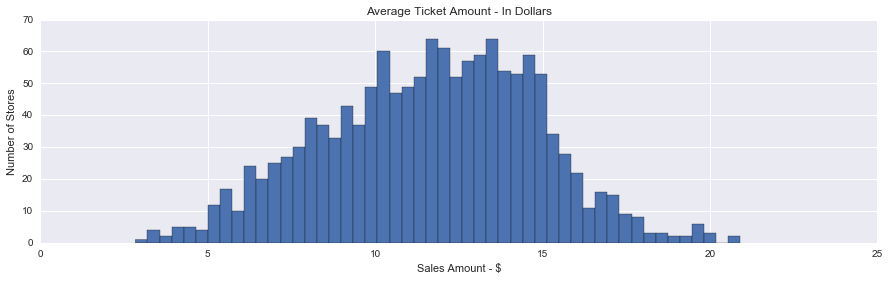

In [115]:
plt.figure(figsize=(15,4))
plt.hist(ias_store_totals_2015['avgticket'],bins=50)
plt.title("Average Ticket Amount - In Dollars")
plt.ylabel("Number of Stores")
plt.xlabel("Sales Amount - $")
plt.show()

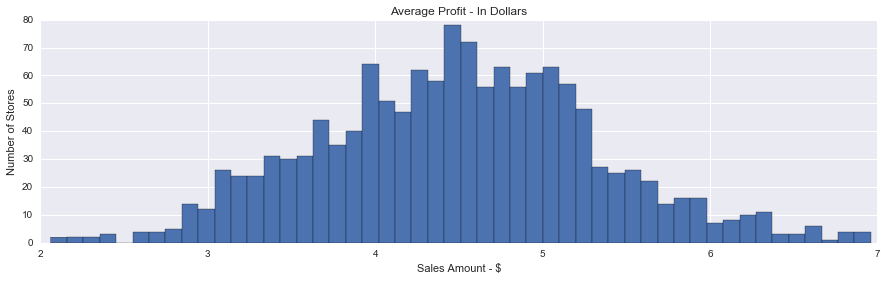

In [116]:
plt.figure(figsize=(15,4))
plt.hist(ias_store_totals_2015['avgprofit'],bins=50)
plt.title("Average Profit - In Dollars")
plt.ylabel("Number of Stores")
plt.xlabel("Sales Amount - $")
plt.show()

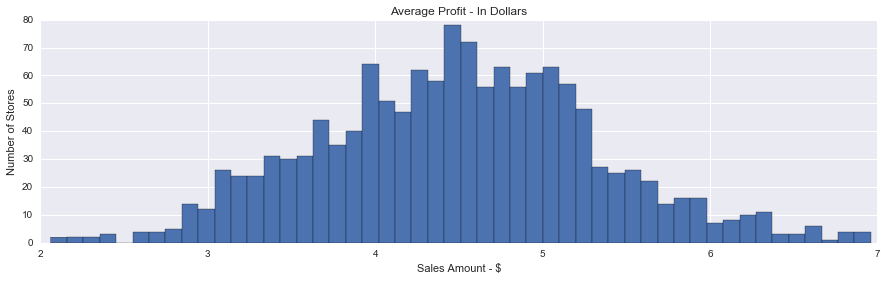

In [117]:
plt.figure(figsize=(15,4))
plt.hist(ias_store_totals_2015['avgprofit'],bins=50)
plt.title("Average Profit - In Dollars")
plt.ylabel("Number of Stores")
plt.xlabel("Sales Amount - $")
plt.show()

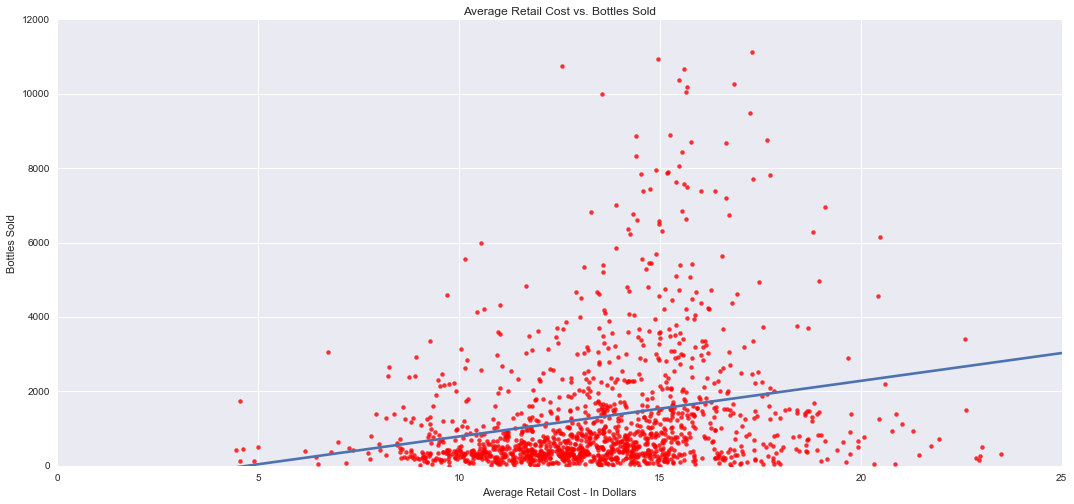

In [143]:
fig, plt1 = plt.subplots()
fig.set_size_inches(18, 8)
sns.regplot(ias_store_totals_2015.avgretail, ias_store_totals_2015.bottles_sold, order=1, ci=None, scatter_kws={'color':'r'})
plt.xlim(xmin=0) 
plt.ylim(ymin=0)
plt.title("Average Retail Cost vs. Bottles Sold")
plt.ylabel("Bottles Sold")
plt.xlabel("Average Retail Cost - In Dollars")
plt.show()

In [146]:
y, X = patsy.dmatrices('bottles_sold ~ avgretail',
                       data=ias_store_totals_2015, 
                       return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:           bottles_sold   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     80.21
Date:                Fri, 23 Sep 2016   Prob (F-statistic):           1.07e-18
Time:                        03:15:46   Log-Likelihood:                -12125.
No. Observations:                1372   AIC:                         2.425e+04
Df Residuals:                    1370   BIC:                         2.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -706.9888    229.481     -3.081      0.0

In [106]:
ias_2015_q1 = ias_2015.loc[(ias_2015['date'] >= '2015-01-01') & 
                           (ias_2015['date'] <= '2015-03-31')].reset_index(drop=True)
ias_2015_q2 = ias_2015.loc[(ias_2015['date'] >= '2015-04-01') & 
                           (ias_2015['date'] <= '2015-06-30')].reset_index(drop=True)
ias_2015_q3 = ias_2015.loc[(ias_2015['date'] >= '2015-07-01') & 
                           (ias_2015['date'] <= '2015-09-30')].reset_index(drop=True)
ias_2015_q4 = ias_2015.loc[(ias_2015['date'] >= '2015-10-01') & 
                           (ias_2015['date'] <= '2015-12-31')].reset_index(drop=True)

ias_2016_q1 = ias_2016.loc[(ias_2016['date'] >= '2016-01-01') & 
                           (ias_2016['date'] <= '2016-03-31')].reset_index(drop=True)

In [206]:
ias_2015_q1_bs = ias_2015_q1.groupby('date')['bottles_sold'].sum()
ias_2015_q2_bs = ias_2015_q2.groupby('date')['bottles_sold'].sum()
ias_2015_q3_bs = ias_2015_q3.groupby('date')['bottles_sold'].sum()
ias_2015_q4_bs = ias_2015_q4.groupby('date')['bottles_sold'].sum()

ias_2016_q1_bs = ias_2016_q1.groupby('date')['bottles_sold'].sum()

ias_2015_q1_br = ias_2015_q1.groupby('date')['sbr'].mean()
ias_2015_q2_br = ias_2015_q2.groupby('date')['sbr'].mean()
ias_2015_q3_br = ias_2015_q3.groupby('date')['sbr'].mean()
ias_2015_q4_br = ias_2015_q4.groupby('date')['sbr'].mean()

ias_2015_q1_bc = ias_2015_q1.groupby('date')['sbc'].mean()
ias_2015_q2_bc = ias_2015_q2.groupby('date')['sbc'].mean()
ias_2015_q3_bc = ias_2015_q3.groupby('date')['sbc'].mean()
ias_2015_q4_bc = ias_2015_q4.groupby('date')['sbc'].mean()

In [207]:
for x in range(0,ias_2015_q1_bs.count()):
    if not np.abs(ias_2015_q1_bs[x]-ias_2015_q1_bs.mean())<=(3*ias_2015_q1_bs.std()):
        ias_2015_q1_bs[x] = ias_2015_q1_bs.mean()
        
for x in range(0,ias_2015_q2_bs.count()):
    if not np.abs(ias_2015_q2_bs[x]-ias_2015_q2_bs.mean())<=(3*ias_2015_q2_bs.std()):
        ias_2015_q2_bs[x] = ias_2015_q2_bs.mean()
        
for x in range(0,ias_2015_q3_bs.count()):
    if not np.abs(ias_2015_q3_bs[x]-ias_2015_q3_bs.mean())<=(3*ias_2015_q3_bs.std()):
        ias_2015_q3_bs[x] = ias_2015_q3_bs.mean()
        
for x in range(0,ias_2015_q4_bs.count()):
    if not np.abs(ias_2015_q4_bs[x]-ias_2015_q4_bs.mean())<=(2*ias_2015_q4_bs.std()):
        ias_2015_q4_bs[x] = ias_2015_q4_bs.mean()


for x in range(0,ias_2016_q1_bs.count()):
    if not np.abs(ias_2016_q1_bs[x]-ias_2016_q1_bs.mean())<=(2*ias_2016_q1_bs.std()):
        ias_2016_q1_bs[x] = ias_2016_q1_bs.mean()

        
        
for x in range(0,ias_2015_q1_br.count()):
    if not np.abs(ias_2015_q1_br[x]-ias_2015_q1_br.mean())<=(3*ias_2015_q1_br.std()):
        ias_2015_q1_br[x] = ias_2015_q1_br.mean()
        
for x in range(0,ias_2015_q2_br.count()):
    if not np.abs(ias_2015_q2_br[x]-ias_2015_q2_br.mean())<=(3*ias_2015_q2_br.std()):
        ias_2015_q2_br[x] = ias_2015_q2_br.mean()
        
for x in range(0,ias_2015_q3_br.count()):
    if not np.abs(ias_2015_q3_br[x]-ias_2015_q3_br.mean())<=(3*ias_2015_q3_br.std()):
        ias_2015_q3_br[x] = ias_2015_q3_br.mean()
        
for x in range(0,ias_2015_q4_br.count()):
    if not np.abs(ias_2015_q4_br[x]-ias_2015_q4_br.mean())<=(3*ias_2015_q4_br.std()):
        ias_2015_q4_br[x] = ias_2015_q4_br.mean()

        
        
for x in range(0,ias_2015_q1_bc.count()):
    if not np.abs(ias_2015_q1_bc[x]-ias_2015_q1_bc.mean())<=(2*ias_2015_q1_bc.std()):
        ias_2015_q1_bc[x] = ias_2015_q1_bc.mean()
        
for x in range(0,ias_2015_q2_bc.count()):
    if not np.abs(ias_2015_q2_bc[x]-ias_2015_q2_bc.mean())<=(2*ias_2015_q2_bc.std()):
        ias_2015_q2_bc[x] = ias_2015_q2_bc.mean()
        
for x in range(0,ias_2015_q3_bc.count()):
    if not np.abs(ias_2015_q3_bc[x]-ias_2015_q3_bc.mean())<=(2*ias_2015_q3_bc.std()):
        ias_2015_q3_bc[x] = ias_2015_q3_bc.mean()
        
for x in range(0,ias_2015_q4_bc.count()):
    if not np.abs(ias_2015_q4_bc[x]-ias_2015_q4_bc.mean())<=(2*ias_2015_q4_bc.std()):
        ias_2015_q4_bc[x] = ias_2015_q4_bc.mean()

In [334]:
ias_2015_q1_bs_weekly = ias_2015_q1_bs.resample('W').sum()
ias_2015_q2_bs_weekly = ias_2015_q2_bs.resample('W').sum()
ias_2015_q3_bs_weekly = ias_2015_q3_bs.resample('W').sum()
ias_2015_q4_bs_weekly = ias_2015_q4_bs.resample('W').sum()

ias_2015_q1_br_weekly = ias_2015_q1_br.resample('W').sum()
ias_2015_q2_br_weekly = ias_2015_q2_br.resample('W').sum()
ias_2015_q3_br_weekly = ias_2015_q3_br.resample('W').sum()
ias_2015_q4_br_weekly = ias_2015_q4_br.resample('W').sum()

ias_2015_q1_bc_weekly = ias_2015_q1_bc.resample('W').sum()
ias_2015_q2_bc_weekly = ias_2015_q2_bc.resample('W').sum()
ias_2015_q3_bc_weekly = ias_2015_q3_bc.resample('W').sum()
ias_2015_q4_bc_weekly = ias_2015_q4_bc.resample('W').sum()

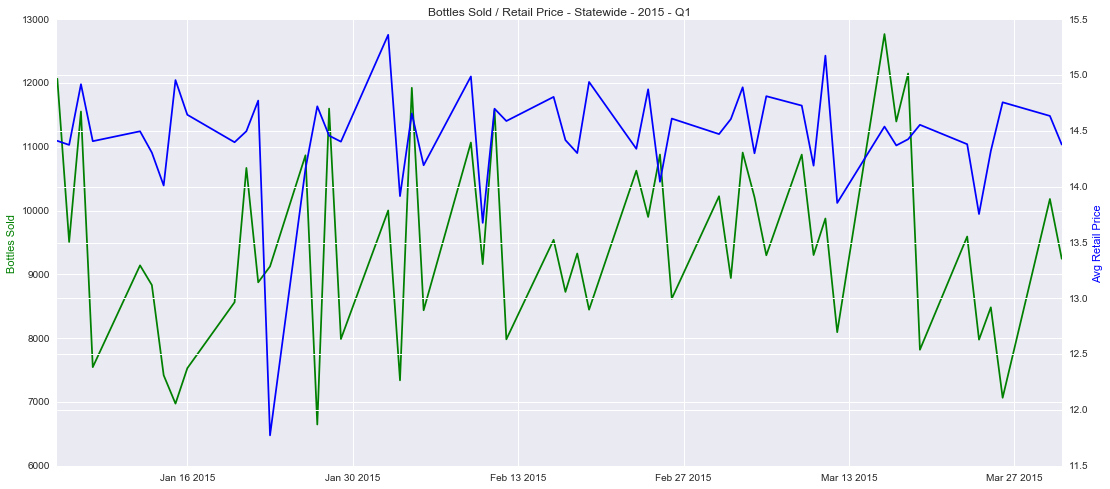

In [343]:
fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q1')
plt1.plot(ias_2015_q1_bs, 'g-')
plt2.plot(ias_2015_q1_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

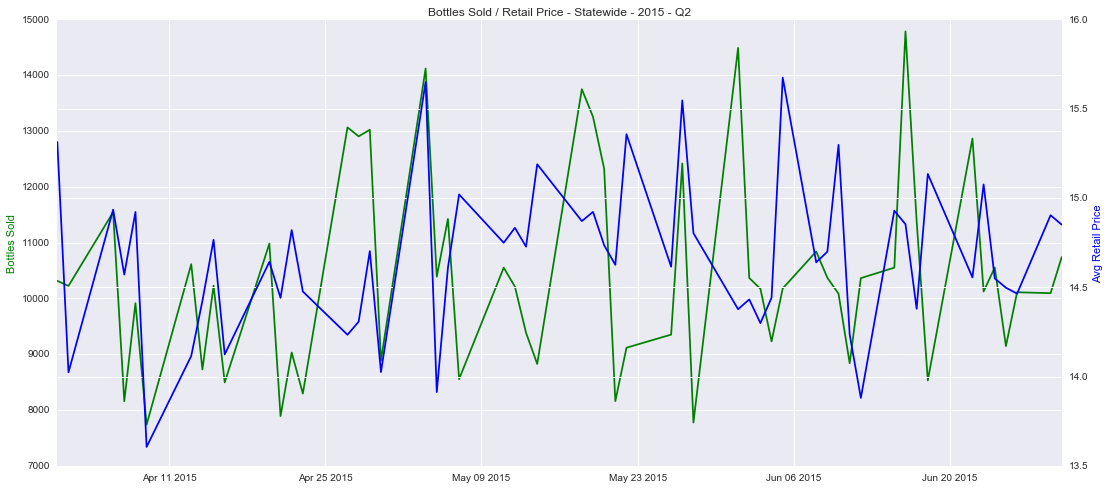

In [346]:
fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q2')
plt1.plot(ias_2015_q2_bs, 'g-')
plt2.plot(ias_2015_q2_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

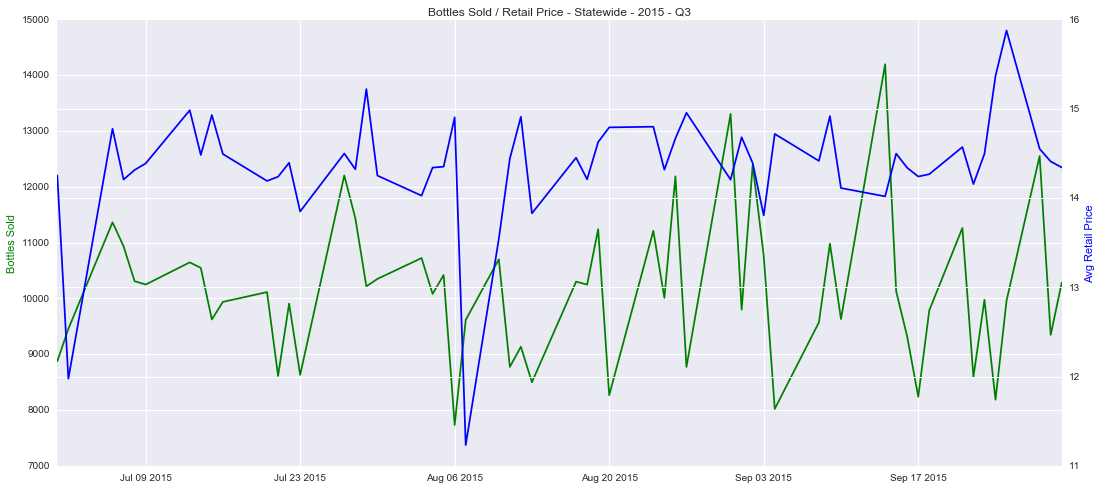

In [347]:
fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q3')
plt1.plot(ias_2015_q3_bs, 'g-')
plt2.plot(ias_2015_q3_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

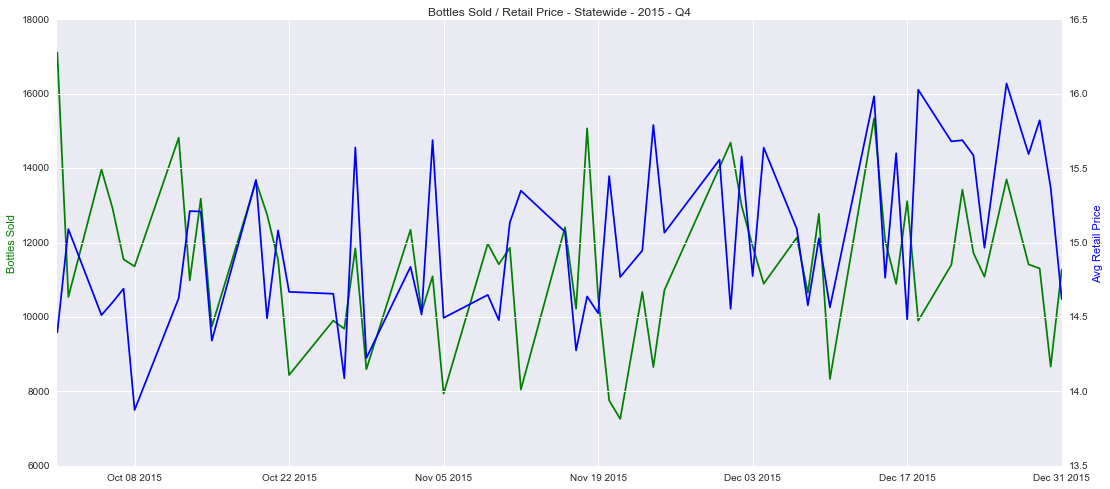

In [351]:
fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)
plt.xlabel('Date')
plt.title('Bottles Sold / Retail Price - Statewide - 2015 - Q4')
plt1.plot(ias_2015_q4_bs, 'g-')
plt2.plot(ias_2015_q4_br, 'b-')
plt1.set_ylabel('Bottles Sold', color='g')
plt2.set_ylabel('Avg Retail Price', color='b')

plt.show()

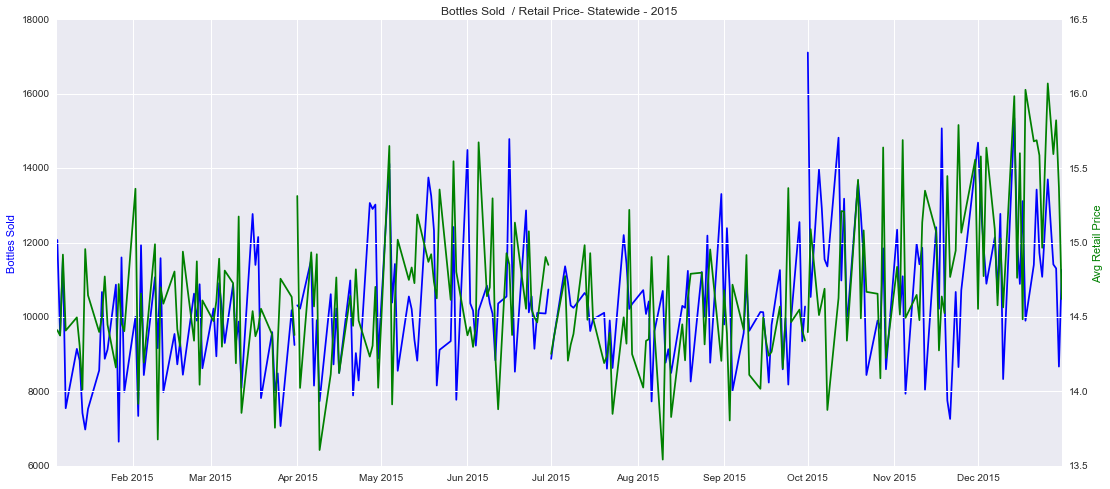

In [451]:
fig, plt1 = plt.subplots()

plt2 = plt1.twinx()

fig.set_size_inches(18, 8)


plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold  / Retail Price- Statewide - 2015')

plt1.plot(ias_2015_q1_bs, 'b-')
plt1.plot(ias_2015_q2_bs, 'b-')
plt1.plot(ias_2015_q3_bs, 'b-')
plt1.plot(ias_2015_q4_bs, 'b-')

plt2.plot(ias_2015_q1_br, 'g-')
plt2.plot(ias_2015_q2_br, 'g-')
plt2.plot(ias_2015_q3_br, 'g-')
plt2.plot(ias_2015_q4_br, 'g-')

plt1.set_ylabel('Bottles Sold', color='b')
plt2.set_ylabel('Avg Retail Price', color='g')
plt.show()

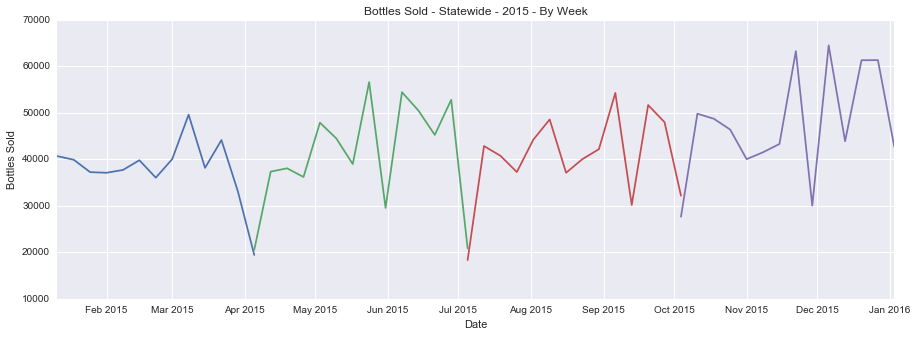

In [173]:
plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2015 - By Week')
plt.plot(ias_2015_q1_bs_weekly)
plt.plot(ias_2015_q2_bs_weekly)
plt.plot(ias_2015_q3_bs_weekly)
plt.plot(ias_2015_q4_bs_weekly)
plt.show()

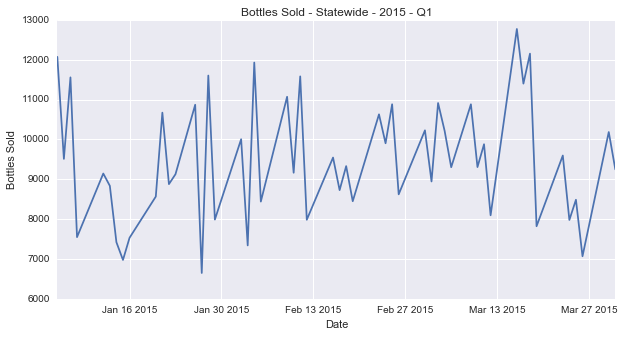

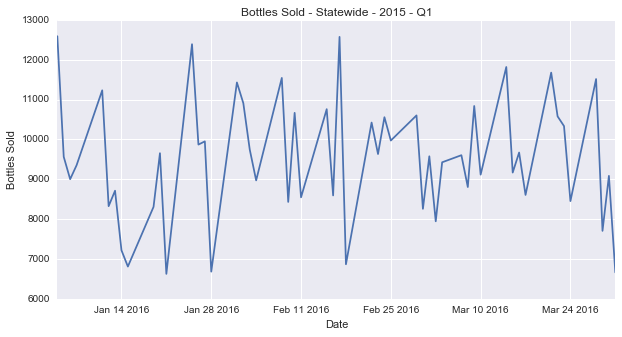

In [210]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2015 - Q1')
plt.plot(ias_2015_q1_bs)
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Bottles Sold')
plt.title('Bottles Sold - Statewide - 2015 - Q1')
plt.plot(ias_2016_q1_bs)
plt.show()


## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [440]:
ias_2015_q1.head()

,date,storenumber,city,zipcode,countynumber,county,category,categoryname,vendornumber,itemnumber,itemdesc,bv_ml,sbc,sbr,bottles_sold,sale_in_dollars,vs_lit,vs_gal
0,2015-01-22,3858,DAVENPORT,52806,82.0,Scott,1012100.0,CANADIAN WHISKIES,65,15248,Windsor Canadian Pet,1750,8.92,-0.108115,-0.394719,-0.320616,1.75,0.46
1,2015-03-04,2614,DAVENPORT,52807,82.0,Scott,1012100.0,CANADIAN WHISKIES,434,13638,Lord Calvert Canadian Whisky,1750,9.97,0.044567,-0.163379,-0.098421,10.50,2.77
2,2015-01-16,2590,CEDAR RAPIDS,52402,57.0,Linn,1031200.0,VODKA FLAVORED,971,41474,44 North Huckleberry,750,14.25,0.664958,-0.348451,-0.235147,1.50,0.40
3,2015-01-13,3942,TOLEDO,52342,86.0,Tama,1012100.0,CANADIAN WHISKIES,115,11786,Black Velvet Traveler,750,5.23,-0.642502,0.114229,-0.085505,9.00,2.38
4,2015-03-24,3981,SIOUX CENTER,51250,84.0,Sioux,1011100.0,BLENDED WHISKIES,260,25606,Seagrams 7 Crown Bl Whiskey,750,7.00,-0.386422,0.114229,0.007003,9.00,2.38


In [236]:
iasmod_2015_q1 = pd.DataFrame(data=ias_2015_q1,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q2 = pd.DataFrame(data=ias_2015_q2,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q3 = pd.DataFrame(data=ias_2015_q3,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])
iasmod_2015_q4 = pd.DataFrame(data=ias_2015_q4,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])

iasmod_2016_q1 = pd.DataFrame(data=ias_2016_q1,columns=
                              ['zipcode','countynumber','category','itemnumber',
                               'sbr','bottles_sold','sale_in_dollars'])

In [460]:
iasmod_2015_q1['zipcode'] = iasmod_2015_q1['zipcode'].astype('int64')
iasmod_2015_q2['zipcode'] = iasmod_2015_q2['zipcode'].astype('int64')
iasmod_2015_q3['zipcode'] = iasmod_2015_q3['zipcode'].astype('int64')
iasmod_2015_q4['zipcode'] = iasmod_2015_q4['zipcode'].astype('int64')

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [ ]:
# create regularize copies of data for comparison of results

cont_feats = ['bottles_sold','sbc', 'sbr', 'sale_in_dollars']
iasmod_2015_q1[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q1[cont_feats]
)
iasmod_2015_q1[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q2[cont_feats]
)
iasmod_2015_q1[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q3[cont_feats]
)
iasmod_2015_q1[cont_feats] = StandardScaler().fit_transform(
    iasmod_2015_q4[cont_feats]
)

In [ ]:
q1_2015_corr = ias_2015_q1.corr()
q2_2015_corr = ias_2015_q2.corr()
q3_2015_corr = ias_2015_q3.corr()
q4_2015_corr = ias_2015_q4.corr()

In [ ]:
a=scatter_matrix(iasmod_2015_q1, alpha=0.2, figsize=(15, 15), diagonal='kde')

In [ ]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q1_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q1_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [ ]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q2_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q2_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [ ]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q3_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q3_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [ ]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(q4_2015_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(q4_2015_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [207]:
# the models are being designed to predict which features are correlated or can be predictors of continuous
# variables 

In [382]:
#cont_feats = ['zipcode','countynumber','sale_in_dollars', 'bottles_sold', 'category']
cont_feats_regr = ['bottles_sold', 'sbr', 'sale_in_dollars']
ias_2015_q1[cont_feats_regr] = StandardScaler().fit_transform(
    ias_2015_q1[cont_feats_regr]
)

In [168]:
search_parameters = {
    "alpha": np.arange(10, -10, -0.01)
}

kf = KFold(len(ias_2015_q1), n_folds=10, shuffle=True, random_state=43)

In [200]:
models = ['sale_in_dollars ~ bottles_sold','sale_in_dollars ~ bottles_sold + sbr', 
          'sale_in_dollars ~ bottles_sold + sbr * category', 
          'sale_in_dollars ~ bottles_sold + sbr * category * vendornumber']

In [194]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q1.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
#    print '---------------------------------------------------------------------'
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.597110885665 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.670643394984 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

bottles_sold ~ sale_in_dollars + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.634419018499 | R^2 in sample : 0.686481766476 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.672826211228 | R^2 in sample : 0.694184845624 |
-------------------------------------

In [480]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q3.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.449676353502 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.549363083967 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.549594907832 | R^2 in sample : 0.692554758089 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.551241942166 | R^2 in sample : 0.694184845528 |
-------------------------------------

In [481]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.575206450149 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.642663552475 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.64292465445 | R^2 in sample : 0.692554758089 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.643955750204 | R^2 in sample : 0.694184845528 |
--------------------------------------

In [473]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q4.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : 0.514140608156 | R^2 in sample : 0.503541299878 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : 0.583767219386 | R^2 in sample : 0.560654616318 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : 0.583622686013 | R^2 in sample : 0.560807531026 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : 0.58503125476 | R^2 in sample : 0.562786102706 |
--------------------------------------

In [ ]:
# Q1 vs 2015 ANNUAL

kf2 = KFold(len(ias_2015), n_folds=10, shuffle=True, random_state=43)

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf2:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2015_q3.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

In [410]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs

In [431]:
kfolds = KFold(ias_2015_q1.shape[0], n_folds=5)

Y, X = patsy.dmatrices(models[2], data=ias_2015_q1)
Yoverfit, Xoverfit = patsy.dmatrices(models[2], data=ias_2015_q1)

In [475]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

l_alphas = np.arange(0, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

enet_alphas = np.arange(0, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # lists to track mean R2s per alpha
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # initialize models
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print 'Lasso...'
    # iterate through Lasso alphas
    for la in l_alphas:
        
        if verbose: print la
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold R2s
        rsqs = []
        
        # iterate through the folds. Each iteration returns the training and
        # testing indices
        for traini, testi in kfolds:
            
            # run the current model with the subset training X and Y
            lasso.fit(X[traini], Y[traini])
            
            # append the R2 on the test set to the tracker
            rsqs.append(lasso.score(X[testi], Y[testi]))
            
        # append the mean of the R2s for this alpha to the R2 by alpha list
        lasso_rsq.append(np.mean(rsqs))

    print 'Ridge...'
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print ra
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds:
            ridge.fit(X[traini], Y[traini])
            rsqs.append(ridge.score(X[testi], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print 'ElasticNet...'
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print ea
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds:
            enet.fit(X[traini], Y[traini])
            rsqs.append(enet.score(X[testi], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds:
        linreg.fit(X[traini], Y[traini])
        linreg_rsq.append(linreg.score(X[testi], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq

/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [476]:
# Get the ridge and lasso cross-validated R2s:
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, enet_alphas, kfolds)

Lasso...


/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Ridge...
ElasticNet...


/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [433]:
overfit_ridge_rsq, overfit_lasso_rsq, overfit_enet_rsq, overfit_linreg_rsq = ridge_lasso_cv_rsq(Xoverfit, Yoverfit,                                                                                                
                                                                                        r_alphas, l_alphas, 
                                                                                        enet_alphas, kfolds)

Lasso...


/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


Ridge...
ElasticNet...


/Users/aaronkim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [477]:
print 'Linear Regression R^2:', linreg_rsq
print 'Ridge best R^2:', np.max(ridge_rsq)
print 'Lasso best R^2:', np.max(lasso_rsq)
print 'ElasticNet best R^2:', np.max(enet_rsq)
print 'Overfitt Linear Regression R^2:', overfit_linreg_rsq
print 'Overfit Ridge best R^2:', np.max(overfit_ridge_rsq)
print 'Overfit Lasso best R^2:', np.max(overfit_lasso_rsq)
print 'Overfit ElasticNet best R^2:', np.max(overfit_enet_rsq)

Linear Regression R^2: 0.763255867778
Ridge best R^2: 0.763356152075
Lasso best R^2: 0.76334663823
ElasticNet best R^2: 0.763349249027
Overfitt Linear Regression R^2: 0.763255867778
Overfit Ridge best R^2: 0.763356152075
Overfit Lasso best R^2: 0.76334663823
Overfit ElasticNet best R^2: 0.763349249027


In [491]:
for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = ias_2016_q4.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print mm
    print '----------------------------------------------------------------------'
    print '| R^2 outof_sample :',np.mean(outof_sample),'| R^2 in sample :', np.mean(in_sample),'|'
    print '----------------------------------------------------------------------\n'

sale_in_dollars ~ bottles_sold
----------------------------------------------------------------------
| R^2 outof_sample : -386.781387675 | R^2 in sample : 0.624880481806 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr
----------------------------------------------------------------------
| R^2 outof_sample : -374.197505501 | R^2 in sample : 0.692142288802 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category
----------------------------------------------------------------------
| R^2 outof_sample : -374.156527672 | R^2 in sample : 0.692554758089 |
----------------------------------------------------------------------

sale_in_dollars ~ bottles_sold + sbr * category * vendornumber
----------------------------------------------------------------------
| R^2 outof_sample : -373.915071112 | R^2 in sample : 0.694184845528 |
-------------------------------------

In [199]:
y, X = patsy.dmatrices(models[1],
                       data=ias_2016_q1, 
                       return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:        sale_in_dollars   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                 7.557e+04
Date:                Fri, 23 Sep 2016   Prob (F-statistic):               0.00
Time:                        04:08:21   Log-Likelihood:            -3.4805e+05
No. Observations:               52361   AIC:                         6.961e+05
Df Residuals:                   52358   BIC:                         6.961e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -110.4641      1.447    -76.316   

In [150]:
outof_sample = []
in_sample = []

alphas = [0.2,0.1,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-1,-2,-4,-6,-9]

for al in alphas:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = ias_2015_q1.iloc[train_index]
        y_train, X_train = patsy.dmatrices(models[2], 
                                           data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train)
        results = model.fit_regularized(alpha=al)
        test_df = ias_2016_q1.iloc[test_index]
        in_sample.append(r2_score( results.predict(X_train) ,y_train))
        y_test, X_test = patsy.dmatrices(models[2], 
                                         data=test_df, return_type='dataframe')
        y_predicted = results.predict(X_test)
        outof_sample.append(r2_score(y_predicted,y_test))
    print 'alpha',al ,'R^2 outof_sample',np.mean(outof_sample),'R^2 in sample', np.mean(in_sample)

alpha 0.2 R^2 outof_sample 0.599431382751 R^2 in sample 0.692426115937
alpha 0.1 R^2 outof_sample 0.599361612763 R^2 in sample 0.692389006804
alpha -0.1 R^2 outof_sample 0.599404030441 R^2 in sample 0.692433002766
alpha -0.2 R^2 outof_sample 0.599324432158 R^2 in sample 0.692311974936
alpha -0.3 R^2 outof_sample 0.599229366919 R^2 in sample 0.692199460086
alpha -0.4 R^2 outof_sample 0.599120406329 R^2 in sample 0.692071804207
alpha -0.5 R^2 outof_sample 0.598997525264 R^2 in sample 0.69192899579
alpha -0.6 R^2 outof_sample 0.59886074769 R^2 in sample 0.691771021055
alpha -0.7 R^2 outof_sample 0.598710035541 R^2 in sample 0.691597882261
alpha -1 R^2 outof_sample 0.598174206862 R^2 in sample 0.690987476041
alpha -2 R^2 outof_sample 0.595485294139 R^2 in sample 0.687971205124
alpha -4 R^2 outof_sample 0.586029036685 R^2 in sample 0.677500350957
alpha -6 R^2 outof_sample 0.57149176694 R^2 in sample 0.661457915132
alpha -9 R^2 outof_sample 0.541673622786 R^2 in sample 0.628407558673


In [201]:
y, X = patsy.dmatrices(models[2],
                       data=ias_2015_q1, 
                       return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:        sale_in_dollars   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                 4.054e+04
Date:                Fri, 23 Sep 2016   Prob (F-statistic):               0.00
Time:                        04:08:51   Log-Likelihood:            -3.2536e+05
No. Observations:               49791   AIC:                         6.507e+05
Df Residuals:                   49786   BIC:                         6.508e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       24.5230     43.408      0.565   

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

In [211]:
for train_index, test_index in kf:
    train_df = ias_2015_q1.iloc[train_index]
    y_train, X_train = patsy.dmatrices(models[2], 
                                           data=train_df, return_type='dataframe')
    model = sm.OLS(y_train, X_train)
    results = model.fit_regularized(alpha=al)
    test_df = ias_2016_q1.iloc[test_index]
    in_sample.append(r2_score( results.predict(X_train) ,y_train))
    y_test, X_test = patsy.dmatrices(models[2], 
                                         data=test_df, return_type='dataframe')
    y_predicted = results.predict(X_test)
    outof_sample.append(r2_score(y_predicted,y_test))



In [242]:
lr = linear_model.LinearRegression()
y = ias_2015_q2.bottles_sold

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = cross_val_predict(lr, iasmod_2016_q1, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

ValueError: Found arrays with inconsistent numbers of samples: [52361 55423]

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.